In [98]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
np.random.seed(1)
torch.manual_seed(1)
torch.set_default_dtype(torch.float64)

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'mps')


In [86]:
data = np.load("./data/data.npz")
X_tr=torch.tensor(data['X_train']).type(torch.float)
Y_tr=torch.tensor(data['Y_train'])
X_te=torch.tensor(data['X_test'])
Y_te=torch.tensor(data['Y_test'])

In [94]:
data       = np.load("./data/ecg_data.npz")
Xtr        = torch.tensor(data["Xtr"]).type(torch.float)     #Clean train
Xtr_noise  = torch.tensor(data["Xtr_noise"]).type(torch.float) #Noisy train
Xte_noise  = torch.tensor(data["Xte_noise"]).type(torch.float) #Noisy test

params = np.load("./data/ecg_params.npz")
W = torch.FloatTensor(params["W"]) #Decoder parameters
V = torch.FloatTensor(params["V"]) #Encoder parameters

In [50]:
class ECGDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

torch.Tensor

In [128]:
class linear_AE(nn.Module):
    def __init__(self, dim,K,lr=0.001):
        super(linear_AE, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(dim, K),
            #nn.ReLU(),
            nn.Linear(K,dim)
        )
        self.lr=lr
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def reconstruct(self,x,W,V):
        self.model[0].weight.data=W
        self.model[1].weight.data=V
        x=self.model(x)
        return x
    
    def loss(self,X,X_hat):
        return torch.mean((X-X_hat)**2)
    
    def dataloader(self,X,Y,batch_size=1024):
        #X_train, X_val, Y_train, Y_val = train_test_split(Xtr, Ytr, test_size=0.2)
        dataset = ArithmeticExpressionDataset(X,Y)
        dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True)
        return dataloader
    
    def fit(self,X,Y,initialize_weights=True):
        if initialize_weights:
            self.model.apply(self.init_weights)
            #self.print_param()
        optimizer=optim.Adam(self.parameters(),lr=self.lr)
        for epoch in range(self.epoch):
            loss=self.loss(X,Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            self.loss_list.append(loss.item())
            if epoch%100==0:
                print(f'epoch:{epoch},loss:{loss.item()}')

    def print_param(self):
        for param in self.parameters():
            print(f'parameter shape:{param.shape}')
            #print(f'parameter value:{param.data}')
    
    @staticmethod
    def plot_loss(X,X_hat):
        time=len(X)
        plt.plot(range(1, time+1), X, label='Noisy Data')
        plt.plot(range(1, time+1), X_hat, label='Reconstructed Data')
        plt.xlabel('Time')
        plt.ylabel('ECG')
        plt.title('Noisy Data vs. Reconstructed Data')
        plt.legend()
        plt.show()

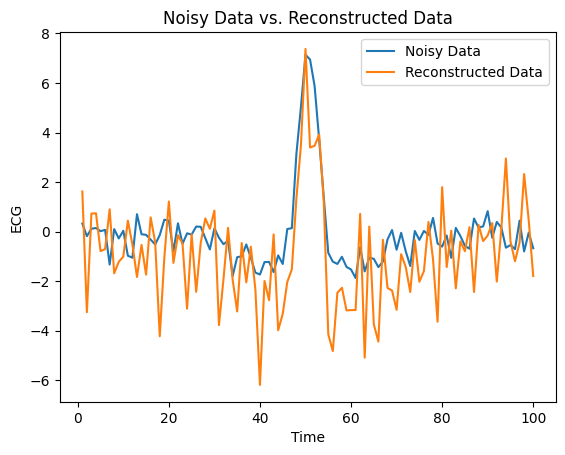

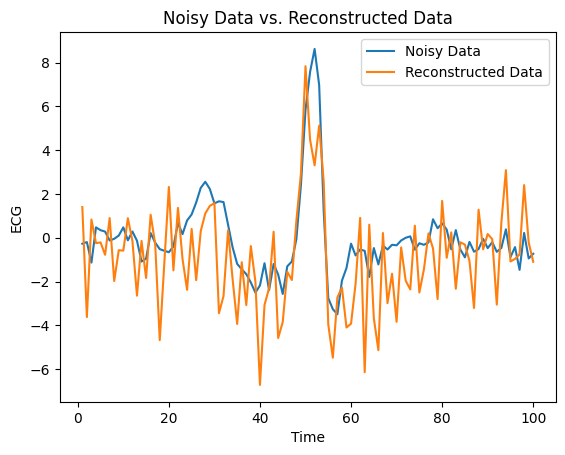

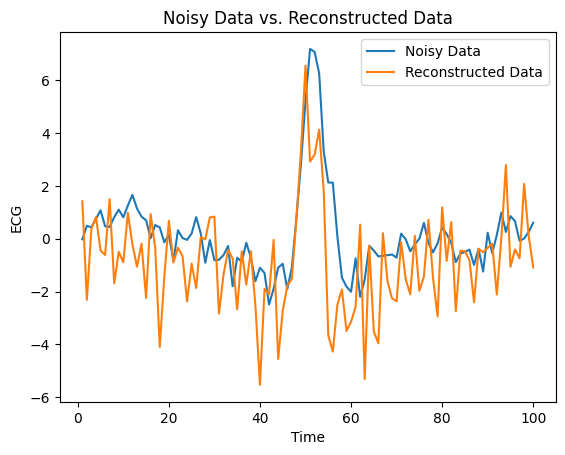

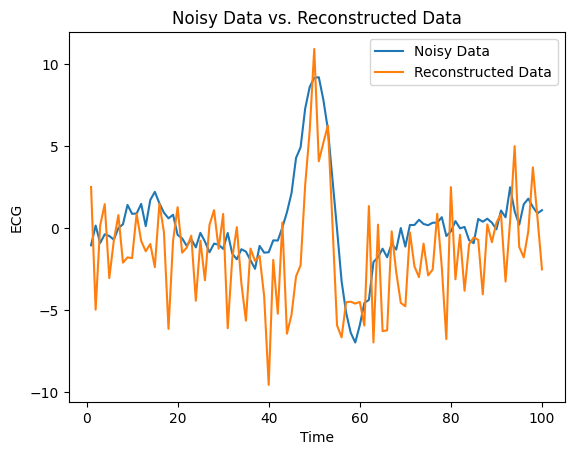

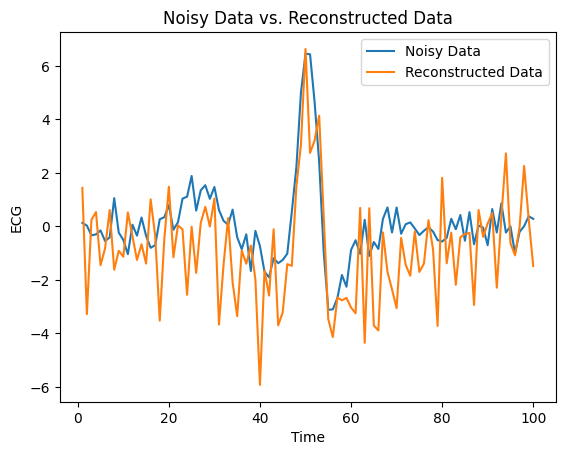

In [133]:
model=linear_AE(100,5)
recon_x=np.ndarray([])
for i in range(5):
    x=model.reconstruct(Xte_noise[i],W.T,V.T)
    x_d=x.detach().numpy()
    np.append(recon_x,x_d)
    model.plot_loss(Xte_noise[i],x_d)

In [131]:
recon_x=torch.tensor(recon_x)
model.loss(recon_x,X_te[:5])

/var/folders/zm/t5q0r2zn06j6v7256cjw7_j80000gn/T/ipykernel_3262/562923132.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x=torch.tensor(recon_x)


tensor(0.0424)

AttributeError: 'list' object has no attribute 'shape'